# Attribute Analysis
The following notebook can analyze a given attribute with any number of expected values (2+), and will perform metrics att_siz, att_cnt, att_dis, att_clu, att_scn generalized to any attribute.

## Instruction
1. Fill in the dataset in section 1.1

2. Run all cells

3. Look at the summary pdf generated AND/OR explore each metric below.
    - All metrics are identified by a short keyword, and consist of a "Setup" and "Analyses" portion. The "Setup" portion contains code that does not need to be modified unless customization is needed, and the "Analyses" portion provides an interactive display of the results.
    
## Table of Contents
1. [Initial Setup](#setup) <br/>
    1.1 [Dataset](#dataset) <br/>
2. att_siz Metric: [Distance from center, size, attribute label inference](#att_size)<br/>
    2.1 [Setup](#att_size_setup)<br/>
    2.2 [Analyses](#att_size_analyses)
3. att_cnt Metric: [Object occurrences and cooccurrences](#att_cnt)<br/>
    3.1 [Setup](#att_cnt_setup)<br/>
    3.2 [Analyses](#att_cnt_analyses)
4. att_dis Metric: [Distance from object as proxy for interaction](#att_dis)<br/>
    4.1 [Setup](#att_dis_setup)<br/>
    4.2 [Analyses](#att_dis_analyses)
5. att_clu Metric: [Linearly seperate objects by attribute](#att_clu)<br/>
    5.1 [Setup](#att_clu_setup)<br/>
    5.2 [Analyses](#att_clu_analyses)
6. att_scn Metric [Scenes](#att_scn)<br/>
    6.1 [Setup](#att_scn_setup)<br/>
    6.2 [Analyses](#att_scn_analyses)
7. [Setting up summary pdf](#summarypdf)

# Initial Setup
<a id="setup"></a>

In [1]:
from __future__ import print_function
from __future__ import division
import argparse
import os
try: # only change dir if necessary
    import datasets
except ModuleNotFoundError:
    os.chdir(os.pardir)
    import datasets
import pickle
import itertools
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from scipy import stats
import PIL.Image
from scipy.cluster.hierarchy import dendrogram, linkage
from math import sqrt
import cv2
import matplotlib.patches as patches
from scipy.spatial.distance import squareform
import pycountry
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import permutation_test_score
import re
import plotly.graph_objects as go
import textwrap
import matplotlib.patches as mpatches
import operator
from matplotlib.font_manager import FontProperties
import imageio
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Layout
import ipywidgets as widgets
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import display
import time
import warnings
import random
from matplotlib.transforms import Bbox
from IPython.display import clear_output
import math

In [2]:
COLORS = sns.color_palette('Set2')
SAME_EXTENT = (-0.5, 6.5, -0.5, 6.5)
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore")

if not os.path.exists("dataloader_files"):
    os.mkdir("dataloader_files")
if not os.path.exists("results"):
    os.mkdir("results")
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")

In [4]:
%matplotlib inline

In [5]:
# https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
def hide_toggle(for_next=False, toggle_text='Toggle show/hide'):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide helper functions')

In [6]:
def folder(num, folder):
    if not os.path.exists("results/{0}/{1}".format(folder, num)):
        os.mkdir("results/{0}/{1}".format(folder, num))
    file = open("results/{0}/{1}/results.txt".format(folder, num), "w")
    return file

# Projecting a set of features into a lower-dimensional subspace with PCA
def project(features, dim):
    standardized = StandardScaler().fit_transform(features)
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(X=standardized)
    return principalComponents

# Calculating the binomial proportion confidence interval
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

def country_to_iso3(country):
    missing = {'South+Korea': 'KOR',
            'North+Korea': 'PRK',
            'Laos': 'LAO',
            'Caribbean+Netherlands': 'BES',
            'St.+Lucia': 'LCA',
            'East+Timor': 'TLS',
            'Democratic+Republic+of+Congo': 'COD',
            'Swaziland': 'SWZ',
            'Cape+Verde': 'CPV',
            'C%C3%B4te+d%C2%B4Ivoire': 'CIV',
            'Ivory+Coast': 'CIV',
            'Channel+Islands': 'GBR'
            }
    try:
        iso3 = pycountry.countries.search_fuzzy(country.replace('+', ' '))[0].alpha_3
    except LookupError:
        try:
            iso3 = missing[country]
        except KeyError:
            iso3 = None
    return iso3

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

def display_filepaths(filepaths, width=100, height=100):
    try: 
        sidebyside = widgets.HBox([widgets.Image(value=open(filepath, 'rb').read(), format='png', width=width, height=height) for filepath in filepaths], layout=Layout(height='{}px'.format(height)))
        display(sidebyside)
    except FileNotFoundError: 
        print('Filepath not found. If using CocoDatasetNoImages Class, some functionality is not available.')

def dec_to_show(p):
    if p < .001:
        return '{:0.3e}'.format(p)
    else:
        return round(p, 3)

## Dataset
Fill in below with dataset and file path names
<a id="dataset"></a>

In [7]:
transform_train = transforms.Compose([ 
        transforms.ToTensor()
        ])
dataset = datasets.CoCoDataset(transform_train)
folder_name = 'coco_example'

# dataset = datasets.OpenImagesDataset(transform_train)
# folder_name = 'openimages_supp'

loading annotations into memory...
Done (t=4.47s)
creating index...
index created!


In [8]:
save_loc = '1_pager_gen'
os.system("rm -r results/{0}/{1}".format(folder_name, save_loc))
file = folder(save_loc, folder_name)
first_pass = True
to_write = {}
if not os.path.exists("checkpoints/{}".format(folder_name)):
    os.mkdir("checkpoints/{}".format(folder_name))

In [9]:
data_folder = None

distances = pickle.load(open("results/{}/att_dis.pkl".format(folder_name), "rb"))
sample_file = distances[0][0][0][3]
if not os.path.exists(sample_file):
    assert data_folder is not None, "initialize data_folder with folder path of your data"
    dataset.init_folder_path(data_folder)
    print("overwriting from_path() function")
    dataset.from_path = dataset.from_path_prerun

In [10]:
attr_names = dataset.attribute_names
num_attrs = len(attr_names)

In [11]:
# Put the attributes in order.
ordinal = True
axis = [1, 2, 3, 4, 5, 6]

# att_siz Metric: Distance from center, size, attribute label inference
<a id="att_siz"></a>

## Setup
<a id="att_siz_setup"></a>

In [12]:
hide_toggle(for_next=True, toggle_text='Show/hide att_siz code')

In [88]:
info = pickle.load(open("results/{}/att_siz.pkl".format(folder_name), "rb"))
sizes = [[y[0] for y in x] for x in info['sizes']]
sizes_paths = [[y[1] for y in x] for x in info['sizes']]
dists = [[y[0] for y in x] for x in info['distances']]
dists_paths = [[y[1] for y in x] for x in info['distances']]
tiny_sizes = [[y[0] for y in x] for x in info['tiny_sizes']]
tiny_paths = [[y[1] for y in x] for x in info['tiny_sizes']]
no_faces = [[y[0] for y in x] for x in info['noface_sizes']]
no_paths = [[y[1] for y in x] for x in info['noface_sizes']]

scenes = [None]*num_attrs
for attr in range(num_attrs):
    try:
        scenes[attr]=np.array(list(itertools.chain.from_iterable([chunk[2] for chunk in no_faces[attr]])) + list(itertools.chain.from_iterable([chunk[1] for chunk in tiny_sizes[attr]])))
    except TypeError:
        if len(tiny_sizes)==0:
            print("There are no images with faces too small to label for group: {0}".format(attr_names[attr]))
        else:
            print("There are no images where a face is not detected for group: {0}".format(attr_names[attr]))
    tiny_sizes[attr] = [chunk[0] for chunk in tiny_sizes[attr]]
    no_faces[attr] = [chunk[0] for chunk in no_faces[attr]]
    
info = pickle.load(open('util_files/places_scene_info.pkl', 'rb'))
idx_to_scene = info['idx_to_scene']
idx_to_scenegroup = info['idx_to_scenegroup']
sceneidx_to_scenegroupidx = info['sceneidx_to_scenegroupidx']

xaxis = [idx_to_scenegroup[i] for i in range(len(idx_to_scenegroup))]
xaxis = ['\n'.join(textwrap.wrap(chunk, width=30)) for chunk in xaxis]
barWidth = .4
fontsize = 15

r1 = np.arange(len(idx_to_scenegroup))
r1 = r1 * ((barWidth * num_attrs) + .2)

scenes = [np.bincount(scenes[i]) for i in range(num_attrs)]
total_images = np.sum(scenes)
scenes_ratio = [scenes[i]/dataset.num_attribute_images[i] for i in range(num_attrs)]
all_sizes = [tiny_sizes[i]+no_faces[i]+sizes[i] for i in range(num_attrs)]
all_paths = [tiny_paths[i]+no_paths[i]+sizes_paths[i] for i in range(num_attrs)]

def numbers_where_attribute_inferred():
    tiny = [len(tiny_sizes[i]) for i in range(num_attrs)]
    noface = [len(no_faces[i]) for i in range(num_attrs)]
    original = [tiny[i]+noface[i]+len(sizes[i]) for i in range(num_attrs)]
    
    total_original = np.sum(original)
    if total_original >0:
        print("Total labelled images: {0},".format(total_original))
    for i in range(num_attrs):
        if original[i]>0:
            print("{0} were {1}".format(original[i], attr_names[i]))
      
    max_original = 0
    max_attribute = -1
    for attr in range(num_attrs):
        if not math.isnan(original[attr]/total_original) and original[attr]/total_original > max_original:
            max_original = original[attr]/total_original
            max_attribute = attr
    if max_attribute > -1:
        print("{0} is assigned to {1}% labelled images in the dataset, and is the most commonly assigned label".format(attr_names[max_attribute], round(max_original, 4)*100))  
    print()
    
    tiny_total = np.sum(tiny)
    if tiny_total > 0:
        print("Discarded {0} images for being too small,".format(tiny_total))
    for i in range(num_attrs):
        if tiny[i]>0:
            print("{0} were {1}".format(tiny[i], attr_names[i]))
        
    max_original = 0
    max_attribute = -1
    for attr in range(num_attrs):
        if not math.isnan(tiny[attr]/tiny_total) and tiny[attr]/tiny_total > max_original:
            max_original = tiny[attr]/tiny_total
            max_attribute = attr
    if max_attribute > -1:
        print("{0} is assigned to {1}% labelled images where a person is too small to properly see, and is the most commonly assigned label among such images".format(attr_names[max_attribute], round(max_original, 4)*100))
    print()
    
    noface_total = np.sum(noface)
    if noface_total >0:
        print("Discarded {0} images for having no face detected,".format(noface_total))
    for i in range(num_attrs):
        if noface[i] >0:
            print("{0} were {1}".format(noface[i], attr_names[i]))
        
    max_original = 0
    max_attribute = -1
    for attr in range(num_attrs):
        if not math.isnan(noface[attr]/noface_total) and noface[attr]/noface_total > max_original:
            max_original = noface[attr]/noface_total
            max_attribute = attr
    if max_attribute > -1:
        print("{0} is assigned to {1}% labelled images where a face is not detected, and is the most commonly assigned label among such images".format(attr_names[max_attribute], round(max_original, 4)*100))
       
    labelled = [tiny[i]+noface[i] for i in range(num_attrs)]
    max_labelled = np.argmax(labelled)
    labelled_others = np.sum(labelled)
    prob = labelled[max_labelled] / labelled_others
    prob_statement = "Probability image is labeled {0} when it should not be, i.e. given there's no face detected or person is too small: {1}".format(attr_names[max_labelled], round(prob, 4))
    if (prob < .45 or prob > .55) and first_pass:
        to_write[0] = ["(att_siz) " + prob_statement]
    print()
    print(prob_statement)
    
def scenes_where_no_face(disp_plt=False):
    barWidths = [barWidth * i for i in range(num_attrs)]
    fig = plt.figure(figsize=(12, 6))
    r = [r1]
    for i in range(1, num_attrs+1):
        r.append([x + barWidth for x in r[len(r)-1]])
        
    scene_attr_ratios = [0 for i in range(len(scenes[0]))]
    max_scenes = [0 for i in range(len(scenes[0]))]
    for scene in range(len(scenes[0])):
        max_scene = 0
        min_scene = 1
        max_attr = -1
        for attr in range(num_attrs):
            if scenes_ratio[attr][scene] > max_scene:
                max_scene = scenes_ratio[attr][scene]
                max_attr = attr
            if scenes_ratio[attr][scene] < min_scene:
                min_scene = scenes_ratio[attr][scene]
        scene_attr_ratios[scene] = max_scene / min_scene
        max_scenes[scene] = max_attr
    
    if disp_plt:
        p_trend, scene_ord_options = [], []
        for scene in range(len(scenes[0])):
            scene_trend = np.array(scenes_ratio)[axis, scene]
            _, _, _, p, _ = stats.linregress([x for x in range(len(axis))], scene_trend)
            p_trend.append(p)
            scene_ord_options.append((f"{xaxis[scene]}, p={dec_to_show(p)}", scene))
        
        scene_ord_options = [x for _, x in sorted(zip(p_trend, scene_ord_options))]
        return scene_ord_options
    else:
        order = np.argsort(scene_attr_ratios)
        biggest_diff_scenes = []
        if first_pass and scene_attr_ratios[order[-1]] > 1.:
            biggest_diff_scenes.append("{0} is the scene where the label of {1} is most likely to be picked over that of others".format(xaxis[order[-1]], attr_names[max_scenes[order[-1]]]))
        if first_pass and scene_attr_ratios[order[0]] < 1.:
            biggest_diff_scenes.append("{0} is the scene where the label of {1} is most likely to be picked over that of others".format(xaxis[order[0]], attr_names[max_scenes[order[0]]]))
        if len(biggest_diff_scenes) > 0:
            to_write[1] = biggest_diff_scenes

        for i in range(num_attrs-1, -1, -1):
            plt.barh(r[i], scenes_ratio[i][order], height=barWidth, color=COLORS[i], edgecolor='white', label=attr_names[i])
        ticks = r[0]+(num_attrs/2)*barWidth
        plt.yticks(ticks, np.array(xaxis)[order], fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.ylabel('Scene', fontsize=fontsize)
        plt.xlabel('Proportion of Labelled Images Discarded with this Scene', fontsize=fontsize)
        plt.legend(loc='best', prop={'size': fontsize})
        plt.title("Scenes where image was labeled when it should not have been", fontsize=fontsize)
        plt.tight_layout()
        plt.gcf().subplots_adjust(bottom=0.18)
        plt.gcf().subplots_adjust(left=0.4)
        plt.show()
    
comparisons_widget = widgets.Dropdown(options=['Sizes', 'Distances', 'All sizes', 'Sizes where no face was detected'], value='Sizes')

def compare_sizedist(metric):
    def mean_and_std(data, data_type):
        mean = [np.mean(data[i]) for i in range(num_attrs)]
        std = [np.std(data[i]) for i in range(num_attrs)]

        min_p = 100
        one = -1
        two = -1
        for i in range(num_attrs):
            for a in range(i+1, num_attrs):
                t, p = stats.ttest_ind(data[i], data[a])
                if p < min_p:
                    min_p=p
                    one = i
                    two = a
        p = min_p
        
        to_save = False
        if metric == 'first_pass' and p < .05 and first_pass:
            data_descrip = ''
            if data_type == 'dists':
                data_descrip = 'Distance from center'
            if data_type == 'sizes':
                data_descrip = 'Fraction of image taken up by a person'
            to_write[2] = ["(att_siz) {0} is different between the attributes with a p-value of {1} for the most significant pair ({2} and {3}), distribution shown below".format(data_descrip, dec_to_show(p), attr_names[one], attr_names[two])]
            to_save = True
            
        if metric == 'first_pass' or metric != 'first_pass':
            for i in range(num_attrs):
                histogram_a, bins_a = np.histogram(data[i], bins='auto')
                bin_centers_a = 0.5*(bins_a[1:] + bins_a[:-1])
                area_a = np.trapz(histogram_a, x=bin_centers_a)
                plt.plot(bin_centers_a, histogram_a/area_a, alpha=.75, label=attr_names[i], color=COLORS[i])

            plt.legend(loc='upper right')
            plt.xlabel('Distances' if data_type == 'dists' else 'Sizes')
            plt.ylabel('Frequency')
            if to_save and first_pass:
                plt.savefig("results/{0}/{1}/0.png".format(folder_name, save_loc))
                plt.close()
            elif metric == 'first_pass':
                plt.close()
            else:
                plt.show()

        if metric != 'first_pass':
            for i in range(num_attrs):
                print("{0}: {1} +- {2}\n".format(attr_names[i], round(mean[i], 4), round(std[i], 4)))
            print("The smallest P value, which is between the groups {} and {}: {}\n".format(attr_names[one],attr_names[two], '{:0.3e}'.format(p)))

    if metric == 'Sizes':
        mean_and_std(sizes, 'sizes')
    elif metric == 'All sizes':
        mean_and_std(all_sizes, 'all_sizes')
    elif metric == 'Sizes where no face was detected':
        mean_and_std(no_faces, 'no_faces')  
    elif metric == 'Distances':
        mean_and_std(dists, 'dists')
    elif metric == 'first_pass' and first_pass:
        mean_and_std(sizes, 'sizes')
        mean_and_std(dists, 'dists')

def ordinal_sizedist(metric, perc=None, disp_plt=True):
    def ordinal_plot(data, data_type):
        mean_data = []
        median_data = []
        
        u, n, n_i_sq, n_i_mult = 0, 0, 0, 0
        for idx_i, i in enumerate(axis):
            a_data = np.array(data[i])
            
            mean_data.append(np.mean(a_data))
            median_data.append(np.median(a_data))
            n += len(a_data)
            n_i_sq += len(a_data)**2
            n_i_mult += len(a_data)**2 * (2 * len(a_data) + 3)
            
            if (idx_i < len(axis)):
                for idx_j, j in enumerate(axis[idx_i + 1:]):
                    b_data = np.array(data[j])
                    for dat in a_data:
                        u += (b_data > dat).sum()
        
        E_U = (n**2 - n_i_sq)/4
        Var_U = (n**2 * (2 * n + 3) - n_i_mult)/72
        Z = (u - E_U)/(Var_U ** 0.5)
        p_trend = stats.norm.sf(abs(Z))
        
        fig=plt.figure()
        mean_ax=fig.add_subplot(111, label='mean')
        med_ax=fig.add_subplot(111, label='median', frame_on=False)

        plt_mean = mean_ax.plot(axis, mean_data, color="C0")[0]
        mean_ax.set_xlabel("Attribute")
        mean_ax.set_ylabel("Mean")

        plt_med = med_ax.plot(axis, median_data, color="C1")[0]
        med_ax.yaxis.tick_right()
        med_ax.set_ylabel("Median")
        med_ax.yaxis.set_label_position("right")
        
        mean_ax.legend([plt_mean, plt_med], ["Mean", "Median"])
        plt.title(f"Mean/Median {data_type} by Attribute, p={dec_to_show(p_trend)}");
        plt.show()
                
    def ordinal_image(data, metric, paths, perc):
        perc_paths = [[] for i in axis]
        perc_data = [[] for i in axis]
        
        for idx_i, i in enumerate(axis):
            a_data = np.array(data[i])
            arg = np.argsort(a_data)
            idxs = arg[np.array([(min(int(len(arg) * k/10), len(arg) - 1)) for k in range(0, 11)])]
            perc_data[idx_i].append(a_data[idxs])
            perc_paths[idx_i].append(np.array(paths[i])[idxs])
        
        fig = plt.figure(figsize=(16, 8))
        perc = int(perc * 10)
        fig.suptitle("Images in the {}-th Percentile of {} (Attribute, {})".format(perc * 10, metric, metric), fontsize=25, y=1.1)

        columns = 3
        rows = math.ceil(len(axis)/columns)
        for i in range(1, len(axis) + 1):
            image, anns = dataset.from_path(perc_paths[i-1][0][perc][0])
            image = image.data.cpu().numpy().transpose(1, 2, 0)
            data = perc_data[i-1][0][perc]
            ax = fig.add_subplot(rows, columns, i)
            
            ann = anns[1][1][int(perc_paths[i-1][0][perc][1])]
            ann_0 = (ann[0]*image.shape[1], ann[2]*image.shape[0])
            ann_w = (ann[1]-ann[0])*image.shape[1]
            ann_h = (ann[3]-ann[2])*image.shape[0]
            rect = patches.Rectangle(ann_0,ann_w, ann_h, linewidth=2,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
            
            if metric=='Distances':
                pt = patches.Circle((image.shape[1]/2, image.shape[0]/2), 4, fill=True, color='r')
                ax.add_patch(pt)
                pt = patches.Circle((ann_0[0] + ann_w/2, ann_0[1] + ann_h/2), 4, fill=True, color='r')
                ax.add_patch(pt)
            
            title = f"{attr_names[axis[i - 1]]}, {data.round(3)}"
            ax.set_title(title, fontsize=15)
            ax.axis("off")

            im = ax.imshow(image, alpha=.66)
        plt.tight_layout()
            
    if metric == 'Sizes':
        if disp_plt:
            ordinal_plot(sizes, 'sizes')
        else:
            ordinal_image(sizes, metric, sizes_paths, perc)
    elif metric == 'All sizes':
        if disp_plt:
            ordinal_plot(all_sizes, 'all_sizes')
        else:
            ordinal_image(all_sizes, metric, all_paths, perc)
    elif metric == 'Sizes where no face was detected':
        if disp_plt:
            ordinal_plot(no_faces, 'no_faces')  
        else:
            ordinal_image(no_faces, metric, no_paths, perc)
    elif metric == 'Distances':
        if disp_plt:
            ordinal_plot(dists, 'dists')
        else:
            ordinal_image(dists, metric, dists_paths, perc)

def disp_ordinal_siz_scn(value):
    def plot_ordinal_scene(scene):
        fig=plt.figure();
        ax=fig.add_subplot(111, label='mean');

        _ = ax.plot(np.array(attr_names)[axis], np.array(scenes_ratio)[axis][:, scene], color="C0")[0];
        ax.set_xlabel("Attribute");
        ax.set_ylabel("Fraction");

        plt.title(f"Fraction of Discarded Attribute Labels in '{xaxis[scene]}'");
        plt.show();
        
    clear_output()
    toggle = widgets.ToggleButtons(options=[('Categorical Plot', False), ('Ordinal Graph', True)], 
                                   value = value['new'],
                                   tooltips=['Display plot with counts of each scene by attribute',
                                             'Display graph showing a statisically significant trend along an ordinal axis'])
    ui = HBox([toggle])
    display(ui)
    
    order = scenes_where_no_face(toggle.value)
    if order is not None:
        ord_selection_widget = widgets.Dropdown(options=order)
        ui_graph = HBox([ord_selection_widget])
        out_graph = widgets.interactive_output(plot_ordinal_scene, {'scene': ord_selection_widget})
        display(ui_graph, out_graph)
        
    toggle.observe(disp_ordinal_siz_scn, 'value')

def disp_discrete_siz():
    if first_pass:
        compare_sizedist('first_pass')
    all_things = [comparisons_widget]
    ui = HBox(all_things)
    out = widgets.interactive_output(compare_sizedist, {'metric': comparisons_widget})
    display(ui, out)

def disp_ordinal_siz(value):
    clear_output()
    toggle = widgets.ToggleButtons(options=[('Categorical Graph', False), ('Ordinal Graph', True)], 
                                   value = value['new'],
                                   tooltips=['Display graph with counts of each category by attribute',
                                             'Display graph showing a statisically significant trend along an ordinal axis'])
    ui = HBox([toggle])
    display(ui)

    if value['new']:
        ui = HBox([comparisons_widget])
        out = widgets.interactive_output(ordinal_sizedist, {'metric': comparisons_widget})
        display(ui, out)
        
        ordinal_widget = widgets.FloatSlider(min=0, max=1.0, step=.1, value=.5, description="Percentile")
        ui = HBox([ordinal_widget])
        out = widgets.interactive_output(ordinal_sizedist, {'metric': comparisons_widget, 'perc': ordinal_widget, 'disp_plt': fixed(False)})
        display(ui, out)
    else: 
        disp_discrete_siz()
        
    toggle.observe(disp_ordinal_siz, 'value')

## Analyses 
<a id="att_siz_analyses"></a>

Statistics on how many attribute labels were inferred when they shouldn't have been because the person was either too small, or no face was detected. The scenes where this happens are shown to investigate if perhaps annotators are relying on contextual clues to make this assumption.

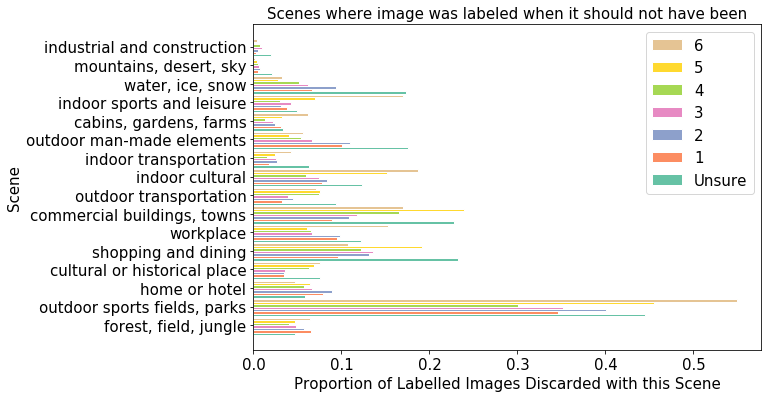

In [84]:
if ordinal:
    disp_ordinal_siz_scn({'new': False})
else:
    numbers_where_attribute_inferred()
    scenes_where_no_face()

Distribution by attribute of sizes and distances, both after removing images where attribute was unlikely to be able to be labeled, all sizes before any images were removed, and the sizes of people where no face was detected.

In [89]:
if ordinal:
    disp_ordinal_siz({'new': False})    
else:
    disp_discrete_siz()

Output()

Output()

# att_cnt Metric: Object occurrences and cooccurrences
<a id="att_cnt"></a>

## Setup
<a id="att_cnt_setup"></a>

In [13]:
hide_toggle(for_next=True, toggle_text='Show/hide att_cnt code')

In [91]:
categories = dataset.categories
names = dataset.labels_to_names
stat = pickle.load(open("results/{}/att_cnt.pkl".format(folder_name), "rb"))
counts = stat['counts']
topn = 10
counts_mat = [np.zeros((len(categories), len(categories))) for i in range(num_attrs)]
for key in counts[0].keys():
    a, b = key.split('-')
    a, b = int(a), int(b)
    for attr in range(num_attrs):
        counts_mat[attr][b][a] = counts[attr][key]
        counts_mat[attr][a][b] = counts[attr][key]
instance_counts = [np.diagonal(counts_mat[i]) for i in range(num_attrs)]
normalized = [np.divide(counts_mat[i], instance_counts[i]) for i in range(num_attrs)]
            
def make_dist(counts, total):
    samples = np.zeros(total)
    samples[:int(counts)] = 1
    return samples

norm_instance_counts = [instance_counts[i]/ dataset.num_attribute_images[i] for i in range(num_attrs)]
xaxis = [names[i] for i in categories]
barWidth = .4

# Looking at if the number of times an object appears with different attributes is statistically significant for all pairs of attributes
p_values = []
attribute_mapping = {}
for i in range(len(instance_counts[0])):
    for a in range(num_attrs):
        for b in range(a+1, num_attrs):
            p_values.append(stats.ttest_ind(make_dist(instance_counts[b][i], dataset.num_attribute_images[b]), make_dist(instance_counts[a][i], dataset.num_attribute_images[a]))[1])
            attribute_mapping[p_values[-1]] = [a, b, xaxis[i]]
    
# Graphs the counts of each supercategory by attribute
def supercategory_by_attribute(ordinal_plot=False):
    if dataset.group_mapping is not None:
        fontsize = 15
        supercategory_counts = [np.zeros(len(datasets.DEFAULT_GROUPINGS_TO_NAMES)) for i in range(num_attrs)]
        for i in range(len(categories)):
            supercat = dataset.group_mapping(categories[i])
            for a in range(num_attrs):
                supercategory_counts[a][supercat] += norm_instance_counts[a][i]
        for a in range(num_attrs):
            supercategory_counts[a] = supercategory_counts[a][1:]
        supercategory_counts = [np.array(supercategory_counts[i]) for i in range(num_attrs)]
        
        if ordinal_plot:
            p_trend, cat_ord_options = [], []
            for idx, count in enumerate(np.array(supercategory_counts).T):
                cat_trend = np.array(count)[axis]
                _, _, _, p, _ = stats.linregress([x for x in range(len(axis))], cat_trend)
                p_trend.append(p)
                cat_ord_options.append((f"{datasets.DEFAULT_GROUPINGS_TO_NAMES[idx + 1]}, p={dec_to_show(p)}", idx))
            cat_ord_options = [x for _, x in sorted(zip(p_trend, cat_ord_options))]    
            return cat_ord_options, np.array(supercategory_counts)[axis].T
        else:
            fig = plt.figure(figsize=(10, 6))
            r1 = np.arange(len(datasets.DEFAULT_GROUPINGS_TO_NAMES)-1)
            r1 = [r1[i]+i*4*barWidth for i in range(len(r1))]
            r = [r1]
            for i in range(1, num_attrs+1):
                r.append([x + barWidth for x in r[len(r)-1]])

            category_attr_ratios = [0 for i in range(len(supercategory_counts[0]))]
            max_categories = [0 for i in range(len(supercategory_counts[0]))]
            for category in range(len(supercategory_counts[0])):
                max_category = 0
                min_category = 1
                max_attr = -1
                for attr in range(num_attrs):
                    if supercategory_counts[attr][category] > max_category:
                        max_category = supercategory_counts[attr][category]
                        max_attr = attr
                    if supercategory_counts[attr][category] < min_category:
                        min_category = supercategory_counts[attr][category]
                category_attr_ratios[category] = max_category / min_category
                max_categories[category] = max_attr

            order = np.argsort(category_attr_ratios)
            r = np.array(r)
            for i in range(num_attrs-1, -1, -1):
                plt.barh(r[i], supercategory_counts[i][order], height=barWidth, color=COLORS[i], edgecolor='white', label=attr_names[i])

            ticks = [r[0]+(num_attrs/2)*barWidth for i in range(len(r1))][0]
            plt.yticks(ticks, np.array([datasets.DEFAULT_GROUPINGS_TO_NAMES[i+1] for i in range(len(r1))])[order], fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.legend(loc='best', fontsize=fontsize)
            plt.ylabel('Object Category', fontsize=fontsize, labelpad=20)
            plt.xlabel('Fraction of Labelled Images that contain this Category', fontsize=fontsize, labelpad=20, x=.3)
            plt.tight_layout()
            plt.gcf().subplots_adjust(bottom=0.18)
            plt.gcf().subplots_adjust(left=0.28)
            if first_pass:
                to_write[3] = ['(att_cnt) Distribution of object categories each attribute appears with, sorted by ratio between the max count attribute and min count attribute.']
                plt.savefig("results/{0}/{1}/1.png".format(folder_name, save_loc))
            plt.show()

# Graphs the ratio of instance counts if they are statistically significant
indices_to_keep = [i for i in range(len(instance_counts[0])) if categories[i] not in dataset.people_labels]
pspecific_indices = []
values_forobject = int((num_attrs)*(num_attrs-1)/2)
        
for ind in indices_to_keep:
    for i in range(ind*(values_forobject),ind*(values_forobject)+(values_forobject)):
        pspecific_indices.append(i)

instance_sig = [norm_instance_counts[i][indices_to_keep] for i in range(num_attrs)]
xaxis_sig = np.array(xaxis)[indices_to_keep]
pvalues_sig = np.array(p_values)[pspecific_indices]
count_attr_ratio = [0 for i in range(len(instance_sig[0]))]
max_counts = [0 for i in range(len(instance_sig[0]))]
for i in range(len(instance_sig[0])):
    max_count = 0
    min_count = 0
    max_attr = -1
    sum_cat = 0
    for attr in range(num_attrs):
        sum_cat += instance_sig[attr][i]
        if instance_sig[attr][i] > max_count:
            max_count = instance_sig[attr][i]
            max_attr = attr
    if sum_cat >0:
        count_attr_ratio[i] = float(max_count) / float(sum_cat)
    else:
        count_attr_ratio[i] = 0
    max_counts[i] = max_attr
all_ratios = np.array(count_attr_ratio)
max_counts = np.array(max_counts)

def show_instance_ratios(sort_by, topn):
    infinities = np.concatenate([np.where(all_ratios == -np.inf)[0], np.where(all_ratios == np.inf)[0]], axis=None)
    infinite_categories = max_counts[infinities]
    
    all_ratios[all_ratios == -np.inf] = 0
    all_ratios[all_ratios == np.inf] = 0

    to_save = False
    if topn is None:
        topn = 5
        to_save = True

    if sort_by == 'pvalue':
        top_indices = np.argsort(pvalues_sig)[:topn][::-1]
        if to_save:
            for i in reversed(range(topn)):
                if pvalues_sig[top_indices[i]] >= .05:
                    top_indices.pop()
            topn = len(top_indices)
            if len(top_indices) == 0:
                return
                to_save = False

        instance_sig_topn = []
        xaxis_sig_topn = []
        all_ratios_topn = []
        max_c = []
        for pval in pvalues_sig[top_indices]:
            info = attribute_mapping[pval]
            index = np.where(xaxis_sig==info[2])
            if instance_sig[info[0]][index][0]*dataset.num_attribute_images[info[0]] > instance_sig[info[1]][index][0]*dataset.num_attribute_images[info[1]]:
                instance_sig_topn.append(instance_sig[info[0]][index][0])
            else:
                instance_sig_topn.append(instance_sig[info[1]][index][0])
            xaxis_sig_topn.append(info[2])
            all_ratios_topn.append(all_ratios[index][0])
            max_c.append(max_counts[index][0])

    elif sort_by == 'ratio':
        top_indices = np.argsort(np.absolute(all_ratios))[-topn:]
        instance_sig_topn = [instance_sig[i][top_indices] for i in range(num_attrs)]
        xaxis_sig_topn = xaxis_sig[top_indices]
        all_ratios_topn = all_ratios[top_indices]
        max_c = max_counts[top_indices]

    fig = plt.figure(figsize=(10, max(2, topn // 3)))
    fontsize = 10
    pltbar = plt.barh(np.arange(topn), np.absolute(all_ratios_topn))

    for bar in range(len(pltbar)):
        pltbar[bar].set_color(COLORS[max_c[bar]])

    plt.yticks(np.arange(topn), xaxis_sig_topn[:topn], rotation='horizontal', fontsize=fontsize)
    ax = plt.gca()
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    ax.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)
    plt.ylabel('Categories', fontsize=fontsize)
    plt.xlabel('Counts Ratio', fontsize=fontsize)
    patches = [mpatches.Patch(color=COLORS[i], label=attr_names[i]) for i in range(num_attrs)]
    handles = patches
    fontP = FontProperties()
    fontP.set_size(12)
    lgd = plt.legend(handles=handles, prop=fontP, loc='best')
    plt.tight_layout()
    if to_save:
        to_write[4] = ['(att_cnt) Objects that are most statistically significantly represented with one attribute over the other.']
        plt.savefig("results/{0}/{1}/2.png".format(folder_name, save_loc))
        plt.close()
        return
    else:
        plt.show()

    if len(infinities) > 0:
        print("Categories where one attribute had 0 occurrences with that object:\n")

    # Categories where all attributes had 0 occurrences with that object
    for index in infinities:
        print("{0} had 0 occurrences with all values of the attribute".format(xaxis_sig_topn[index]))

    print("The most common attribute associated each category in the graph is:\n")
    for index in reversed(range(topn)):
        attr = int(max_c[index])
        if sort_by == 'pvalue':
            instance_sig_top = instance_sig_topn[index]
        elif sort_by == 'ratio':
            instance_sig_top = instance_sig_topn[attr][index]
        print("{0}: {1}={2}, proportion of total instances: {3}\n".format(xaxis_sig_topn[index], attr_names[attr], math.ceil(instance_sig_top*dataset.num_attribute_images[attr]), round(np.absolute(all_ratios_topn[index]), 4)))

p_values = np.zeros_like(counts_mat[0])
attributes = np.array([[[-1,-1] for a in range(len(counts_mat[0][0]))] for b in range(len(counts_mat[0]))])
mi = [np.zeros_like(counts_mat[0]) for a in range(num_attrs)]
mi_wilson = [np.zeros_like(counts_mat[0]) for a in range(num_attrs)]

for i in range(len(categories)):
    for j in range(len(categories)):
        if categories[i] in dataset.people_labels or categories[j] in dataset.people_labels:
            p_values[i][j] = -1
        else:
            min_p = float('inf')
            attr1 = -1
            attr2 = -1
            for a in range(num_attrs):
                for b in range(a+1, num_attrs):
                    len_a = instance_counts[a][j] + instance_counts[a][i] - counts_mat[a][i][j]
                    an = np.zeros(int(len_a))
                    an[:int(counts_mat[a][i][j])] = 1
                    mi[a][i][j] = np.mean(an)
                    mi_wilson[a][i][j] = wilson(np.mean(an), len_a)[0]
                    
                    len_b = instance_counts[b][j] + instance_counts[b][i] - counts_mat[b][i][j]
                    bn = np.zeros(int(len_b))
                    bn[:int(counts_mat[b][i][j])] = 1
                    mi[b][i][j] = np.mean(bn)
                    mi_wilson[b][i][j] = wilson(np.mean(bn), len_b)[0]
                    p = stats.ttest_ind(an, bn)[1]
                    if p < min_p:
                        min_p = p
                        attr1 = a
                        attr2 = b
            p_values[i][j] = p
            attributes[i][j][0] = attr1
            attributes[i][j][1] = attr2
flat_p = p_values.flatten()
flat_p[flat_p!=flat_p] = float("inf")
flat_p[flat_p == -1] = float("inf")

flat_attributes = attributes.flatten()
attributes_dict = {}
for i in range(len(flat_p)):
    #Per 2 attributes in a ttest
    attributes_dict[flat_p[i]] = [flat_attributes[2*i], flat_attributes[2*i+1]]
    
normalized_indices = np.argsort(flat_p)

def cooccurrence_counts_mi(topn):
    print("Statistically significant mutual information:\n")
    i, j = 0, 0
    while j < topn:
        index = normalized_indices[i]
        a, b = index % len(categories), index // len(categories)
        if a < b:
            attr1 = attributes_dict[flat_p[index]][0]
            attr2 = attributes_dict[flat_p[index]][1]
            print("{0} - {1}: {2}".format(names[categories[a]], names[categories[b]], '{:0.3e}'.format(flat_p[index])))
            print("{0}: {1}, {2}: {3}".format(attr_names[attr1], round(mi[attr1].flatten()[index], 4), attr_names[attr2], round(mi[attr2].flatten()[index], 4)))
            print()
            j += 1
        i += 1
        
def disp_ordinal_cnt_supercat(value):
    def plot_ordinal_supercat(cat, supercat_ord):
        fig=plt.figure();
        ax=fig.add_subplot(111, label='mean');
        _ = ax.plot(np.array(attr_names)[axis], np.array(supercat_ord)[cat], color="C0")[0];
        ax.set_xlabel("Attribute");
        ax.set_ylabel("Fraction");

        plt.title(f"Fraction of Images Containing '{datasets.DEFAULT_GROUPINGS_TO_NAMES[cat + 1]}'");
        plt.show();
        
    clear_output()
    toggle = widgets.ToggleButtons(options=[('Bar Plot', False), ('Ordinal Graph', True)], 
                                   value=value['new'],
                                   tooltips=['Display bar plot with counts of each category by attribute',
                                             'Display graph showing a statisically significant trend along an ordinal axis'])
    ui = HBox([toggle])
    display(ui)
    if value['new']:
        order, supercategory_ord = supercategory_by_attribute(toggle.value)
        if order is not None:
            ord_selection_widget = widgets.Dropdown(options=order)
            ui_graph = HBox([ord_selection_widget])
            out_graph = widgets.interactive_output(plot_ordinal_supercat, {'cat': ord_selection_widget, 'supercat_ord': fixed(supercategory_ord)})
            display(ui_graph, out_graph)
    else:
        supercategory_by_attribute()

    toggle.observe(disp_ordinal_cnt_supercat, 'value')
    
def disp_ordinal_cnt_cat(value):
    def plot_ordinal_cat(cat, count):
        fig=plt.figure();
        ax=fig.add_subplot(111, label='mean');
        _ = ax.plot(np.array(attr_names)[axis], np.array(count)[axis, cat], color="C0")[0];
        ax.set_xlabel("Attribute");
        ax.set_ylabel("Fraction");

        plt.title(f"Fraction of Objects Coocurring with '{xaxis[cat]}'");
        plt.show();
        
    clear_output()
    toggle = widgets.ToggleButtons(options=[('Bar Plot', False), ('Ordinal Graph', True)], 
                                   value=value['new'],
                                   tooltips=['Display bar plot with counts of each category by attribute',
                                             'Display graph showing a statisically significant trend along an ordinal axis'])
    ui = HBox([toggle])
    display(ui)
    if value['new']:
        norm_ord_counts = np.array(norm_instance_counts)
        cat_ordinal_options, p_trend = [], []
        for i in range(norm_ord_counts.shape[1]):
            count = norm_ord_counts[axis, i]
            _, _, _, p, _ = stats.linregress([x for x in range(len(axis))], count)
            p_trend.append(p)
            cat_ordinal_options.append((f"{xaxis[i]}, p={dec_to_show(p)}", i))
            
        cat_ordinal_options = [x for _, x in sorted(zip(p_trend, cat_ordinal_options))]
        ord_selection_widget = widgets.Dropdown(options=cat_ordinal_options)
        ui_graph = HBox([ord_selection_widget])
        out_graph = widgets.interactive_output(plot_ordinal_cat, {'cat': ord_selection_widget, 'count':fixed(norm_ord_counts)})
        display(ui_graph, out_graph)
    else:
        discrete_cnt_cat()

    toggle.observe(disp_ordinal_cnt_cat, 'value')

def discrete_cnt_cat():
    instanceratio_slider = widgets.IntSlider(min=5, max=50, step=1, value=10)
    instanceratio_sortby = widgets.Dropdown(options=['pvalue', 'ratio'], value='pvalue')

    if first_pass:
        show_instance_ratios('pvalue', None)

    all_things = [instanceratio_sortby, instanceratio_slider]
    ui = HBox(all_things)
    out = widgets.interactive_output(show_instance_ratios, {'sort_by': instanceratio_sortby, 'topn': instanceratio_slider})
    display(ui, out)

## Analysis
<a id="att_cnt_analyses"></a>

Distribution of object categories by attribute

In [25]:
if dataset.group_mapping is not None:
    if ordinal:
        disp_ordinal_cnt_supercat({'new': False})
    else:
        supercategory_by_attribute()

Output()

Ratio between how often an object is represented with each attribute (normalized), sorted by p-value or ratio.

In [92]:
if dataset.group_mapping is not None:
    if ordinal:
        disp_ordinal_cnt_cat({'new': False})
    else:
        discrete_cnt_cat()

Output()

Most statistically significant object cooccurrences, measured by mutual information, between the attributes. The p-value is shown for the difference of the distributions, and the numbers for each specific attribute value indicate the mutual information for each attribute on the object pair.

In [27]:
interact(cooccurrence_counts_mi, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

interactive(children=(IntSlider(value=10, description='topn', max=30, min=1), Output()), _dom_classes=('widget…

# att_dis Metric : Distance from object as proxy for interaction
<a id="att_dis"></a>

## Setup
<a id="att_dis_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide att_dis code')

In [93]:
categories = dataset.categories
names = dataset.labels_to_names
distances = pickle.load(open("results/{}/att_dis.pkl".format(folder_name), "rb"))
topn = 10

attr_dists = []
attr_distr_dists = []
attr_file_paths = []
attr_indices = []
attr_person = []
p_values = []
ratio_idxs = []
xaxis = []
i_list = []
p_vals = []
cat_ordinal_options = []
mean_dists = [[0 for j in range(len(axis))] for i in range(len(categories))]
median_dists = [[0 for j in range(len(axis))] for i in range(len(categories))]
dists_ord, paths_ord, ann_indices_ord, person_indices_ord = {}, {}, {}, {}

for i in range(len(categories)):
    largest_ratio = -1
    ratio_idx = -1
    for j in range(num_attrs):
        a_dist = np.array([ (chunk[0] / np.sqrt(chunk[1]*chunk[2])) for chunk in distances[i][j] if chunk[2] != 0 and chunk[1] != 0])
        a_file = np.array([ chunk[3] for chunk in distances[i][j] if chunk[2] != 0 and chunk[1] != 0])
        a_index = np.array([ chunk[4] for chunk in distances[i][j] if chunk[2] != 0 and chunk[1] != 0])
        a_person = np.array([ chunk[5] for chunk in distances[i][j] if chunk[2] != 0 and chunk[1] != 0])
        b_dist, b_file, b_index, b_person = [], [], [], []
        for k in range(num_attrs):
            b_dist.extend([(chunk[0] / np.sqrt(chunk[1]*chunk[2])) for chunk in distances[i][k] if chunk[2] != 0 and chunk[1] != 0 and j != k])
            b_file.extend([chunk[3] for chunk in distances[i][k] if chunk[2] != 0 and chunk[1] != 0 and j != k])
            b_index.extend([chunk[4] for chunk in distances[i][k] if chunk[2] != 0 and chunk[1] != 0 and j != k])
            b_person.extend([chunk[5] for chunk in distances[i][k] if chunk[2] != 0 and chunk[1] != 0 and j != k])
        
        t, p = stats.ttest_ind(a_dist, b_dist, equal_var=False)
        a_mean = np.mean(a_dist)
        b_mean = np.mean(b_dist)
        if not np.isnan(a_mean) and not np.isnan(b_mean) and len(a_dist) > 5 and len(b_dist) > 5:
            if (p < 0.05):
                attr_dists.append([a_mean, b_mean])
                attr_distr_dists.append([a_dist, b_dist])
                attr_file_paths.append([a_file, b_file])
                attr_indices.append([a_index, b_index])
                attr_person.append([a_person, b_person])
                p_values.append(p)
                ratio_idxs.append(j)
                xaxis.append(names[categories[i]])
                i_list.append(i)
        
        if (num_attrs == 2):
            break
        
    if (ordinal and num_attrs > 2 and categories[i] not in dataset.people_labels):
        u, n, n_i_sq, n_i_mult = 0, 0, 0, 0
        accum_dists = []
        for idx_j, j in enumerate(axis):
            a_dist = np.array([ (chunk[0] / np.sqrt(chunk[1]*chunk[2])) for chunk in distances[i][j] if chunk[2] != 0 and chunk[1] != 0])
            if (len(a_dist) == 0):
                continue
            accum_dists.append(a_dist)
            mean_dists[i][idx_j] = np.mean(a_dist)
            median_dists[i][idx_j] = np.median(a_dist)
            n += len(a_dist)
            n_i_sq += len(a_dist)**2
            n_i_mult += len(a_dist)**2 * (2 * len(a_dist) + 3)
            
            if (idx_j < len(axis)):
                for idx_k, k in enumerate(axis[idx_j + 1:]):
                    b_dist = np.array([(chunk[0] / np.sqrt(chunk[1]*chunk[2])) for chunk in distances[i][k] if chunk[2] != 0 and chunk[1] != 0])
                    for dist in a_dist:
                        u += (b_dist > dist).sum()

        E_U = (n**2 - n_i_sq)/4
        Var_U = (n**2 * (2 * n + 3) - n_i_mult)/72
        Z = (u - E_U)/(Var_U ** 0.5)
        p_trend = stats.norm.sf(abs(Z))
        
        if(p_trend < 0.05):
            p_vals.append(p_trend)
            cat_ordinal_options.append(((names[categories[i]], p_trend), i))
            if i not in dists_ord:
                dists_ord[i], paths_ord[i], ann_indices_ord[i], person_indices_ord[i] = [], [], [], []
            for idx, dist in zip(axis, accum_dists):
                arg = np.argsort(dist)
                idxs = arg[np.array([(min(int(len(arg) * k/10), len(arg) - 1)) for k in range(0, 11)])]
                dists_ord[i].append(dist[idxs])
                paths_ord[i].append(np.array([chunk[3] for chunk in distances[i][idx] if chunk[2] != 0 and chunk[1] != 0])[idxs])
                ann_indices_ord[i].append(np.array([chunk[4] for chunk in distances[i][idx] if chunk[2] != 0 and chunk[1] != 0])[idxs])
                person_indices_ord[i].append(np.array([chunk[5] for chunk in distances[i][idx] if chunk[2] != 0 and chunk[1] != 0])[idxs])

cat_ordinal_options.sort(key=lambda x:x[0][1])
cat_ordinal_options[:] = [(f"{x}, p={dec_to_show(y)}", z) for (x, y), z in cat_ordinal_options]
mean_dists = np.array(mean_dists)
# Only retaining information for distances that are not people
indices_to_keep = [i for i in range(len(attr_dists)) if categories[i_list[i]] not in dataset.people_labels]
attr_sig_dists = np.array(attr_dists)[indices_to_keep]
attr_distr_dists = np.array(attr_distr_dists)[indices_to_keep]
attr_file_paths = np.array(attr_file_paths)[indices_to_keep]
attr_indices = np.array(attr_indices)[indices_to_keep]
attr_person = np.array(attr_person)[indices_to_keep]
xaxis_sig = np.array(xaxis)[indices_to_keep]
pvalues_sig = np.array(p_values)[indices_to_keep]
ratio_idxs = np.array(ratio_idxs)[indices_to_keep]

all_ratios = []
for i in range(len(attr_sig_dists)):
    in_count = attr_sig_dists[i][0]
    out_count = attr_sig_dists[i][1]
    if in_count > out_count:
        all_ratios.append(in_count/out_count)
    else:
        all_ratios.append(out_count/-in_count)

all_ratios = np.array(all_ratios)
distance_ratio_options = [("{0}, {3}: p-value {1}, {2}x".format(xaxis_sig[i], '{:0.2e}'.format(pvalues_sig[i]), round(all_ratios[i], 3), attr_names[ratio_idxs[i]].lower()), i) for i in np.argsort(pvalues_sig)]

def show_ordinal_trends(cat):
    fig=plt.figure()
    mean_ax=fig.add_subplot(111, label='mean')
    med_ax=fig.add_subplot(111, label='median', frame_on=False)
    
    plt_mean = mean_ax.plot(axis, mean_dists[cat], color="C0")[0]
    mean_ax.set_xlabel("Attribute")
    mean_ax.set_ylabel("Mean Distance")
    
    plt_med = med_ax.plot(axis, median_dists[cat], color="C1")[0]
    med_ax.yaxis.tick_right()
    med_ax.set_ylabel("Median Distance")
    med_ax.yaxis.set_label_position("right")
    
    mean_ax.legend([plt_mean, plt_med], ["Mean", "Median"])
    
    plt.title(f"Mean/Median Distance of '{names[categories[cat]]}' by Attribute");
    plt.show()

def show_ordinal_images(cat, perc):    
    fig = plt.figure(figsize=(16, 8))
    perc = int(perc * 10)
    fig.suptitle("Images in the {}-th Percentile of Distance (Attribute, Distance)".format(perc * 10), fontsize=25, y=1.1)

    columns = 3
    rows = math.ceil(len(axis)/columns)
    for i in range(1, len(axis) + 1):
        image, anns = dataset.from_path(paths_ord[cat][i-1][perc])
        image = image.data.cpu().numpy().transpose(1, 2, 0)
        ann_index = ann_indices_ord[cat][i-1][perc]
        pers_idx = person_indices_ord[cat][i-1][perc]
        dist = dists_ord[cat][i-1][perc]
        ax = fig.add_subplot(rows, columns, i)
        
        ann = anns[0][ann_index]['bbox']
        ann_0 = (ann[0]*image.shape[1], ann[2]*image.shape[0])
        ann_w = (ann[1]-ann[0])*image.shape[1]
        ann_h = (ann[3]-ann[2])*image.shape[0]
        
        per = anns[1][1][pers_idx]
        per_0 = (per[0]*image.shape[1], per[2]*image.shape[0])
        per_w = (per[1]-per[0])*image.shape[1]
        per_h = (per[3]-per[2])*image.shape[0]
        rect = patches.Rectangle(per_0,per_w, per_h, linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

        rect = patches.Rectangle(ann_0,ann_w, ann_h, linewidth=2,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
        
        title = f"{attr_names[axis[i - 1]]}, {dist.round(3)}"
        ax.set_title(title, fontsize=15)
        ax.axis("off")
        
        im = ax.imshow(image, alpha=.66)
    plt.tight_layout()
        
def show_distance_ratios(sort_by, topn):
    topn = min(topn, pvalues_sig.shape[0])
    if sort_by == 'pvalue':
        top_indices = np.argsort(pvalues_sig)[:topn][::-1]
    elif sort_by == 'ratio':
        top_indices = np.argsort(np.absolute(all_ratios))[-topn:]
        
    fontsize = 10
    fig = plt.figure(figsize=(8, max(2, topn // 3)))
    
    all_ratios_topn = all_ratios[top_indices]
    xaxis_sig_topn = xaxis_sig[top_indices]
    all_idxs = ratio_idxs[top_indices]

    pltbar = plt.barh(np.arange(topn), all_ratios_topn, tick_label=xaxis_sig_topn, color=['C' + str(all_idxs[j]) for j in range(len(all_idxs))])
    plt.xlim(min(-np.abs(np.min(all_ratios_topn)), -np.abs(np.max(all_ratios_topn))) - 1, max(np.abs(np.min(all_ratios_topn)), np.abs(np.max(all_ratios_topn))) + 1)
    
    handles = []
    for att in range(num_attrs):
        patch = mpatches.Patch(color='C' + str(att), label=attr_names[att])
        handles.append(patch)

    fontP = FontProperties()
    fontP.set_size(12)
    lgd = plt.legend(handles=handles, prop=fontP)
    plt.xlabel('Proximity', fontsize=fontsize)
    plt.ylabel('Categories', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()        
    plt.show()

distanceratio_slider = widgets.IntSlider(min=5, max=50, step=1, value=10)
distanceratio_sortby = widgets.Dropdown(options=['pvalue', 'ratio'], value='pvalue')

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Saves qualitative images for each of the quartiles of distance
def save_box_images(bpa, a_array, file_paths_a, indices_a, person_a, bpb, b_array, file_paths_b, indices_b, person_b, names, cat_index, to_save=False):
    a = bpa['whiskers'][0].get_data()[1][1]
    b = bpa['whiskers'][0].get_data()[1][0]
    c = bpa['medians'][0].get_data()[1][0]
    d = bpa['whiskers'][1].get_data()[1][0]
    e = bpa['whiskers'][1].get_data()[1][1]
    box_nums_a = [a, b, c, d, e]
    a = bpb['whiskers'][0].get_data()[1][1]
    b = bpb['whiskers'][0].get_data()[1][0]
    c = bpb['medians'][0].get_data()[1][0]
    d = bpb['whiskers'][1].get_data()[1][0]
    e = bpb['whiskers'][1].get_data()[1][1]
    box_nums_b = [a, b, c, d, e]
    fig = plt.figure(figsize=(16, 8))
    for k in range(2):
        for j in range(5):
            if k == 0:
                index = find_nearest(a_array, box_nums_a[j])
                indices = indices_a
                file_paths = file_paths_a
                pers_indices = person_a
            else:
                index = find_nearest(b_array, box_nums_b[j])
                indices = indices_b
                file_paths = file_paths_b
                pers_indices = person_b
            file_path = file_paths[index]
            ann_index = indices[index]
            image, anns = dataset.from_path(file_path)
            image = image.data.cpu().numpy().transpose(1, 2, 0)
            
            if k == 0:
                ax = fig.add_subplot(2, 5, j+1)
            else:
                ax = fig.add_subplot(2, 5, j+6)
            
            ann = anns[0][ann_index]['bbox']
            ann_0 = (ann[0]*image.shape[1], ann[2]*image.shape[0])
            ann_w = (ann[1]-ann[0])*image.shape[1]
            ann_h = (ann[3]-ann[2])*image.shape[0]
            per = anns[1][1][pers_indices[index]]
            per_0 = (per[0]*image.shape[1], per[2]*image.shape[0])
            per_w = (per[1]-per[0])*image.shape[1]
            per_h = (per[3]-per[2])*image.shape[0]
            rect = patches.Rectangle(per_0,per_w, per_h, linewidth=2,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            rect = patches.Rectangle(ann_0,ann_w, ann_h, linewidth=2,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
            
            title = 'min'
            if j == 1:
                title = 'lower quartile'
            elif j == 2:
                title = 'median'
            elif j == 3:
                title = 'upper quartile'
            elif j == 4:
                title = 'max'
            ax.set_title(title, fontsize=15)
            ax.axis("off")
            if all_ratios[cat_index] < 0:
                top_hl = "Closer"
                bottom_hl = "Further"
            else:
                top_hl = "Further"
                bottom_hl = "Closer"

            fig.suptitle("{} (Top, {}) vs NOT-{} (Bottom, {})".format(attr_names[ratio_idxs[cat_index]].upper(), top_hl, attr_names[ratio_idxs[cat_index]].upper(), bottom_hl), fontsize=16)
            im = ax.imshow(image, alpha=.66)

    if to_save:
        if np.mean(a_array) < np.mean(b_array):
            closer_sent = attr_names[ratio_idxs[cat_index]] + " are closer than any other attribute."
        else:
            closer_sent = attr_names[ratio_idxs[cat_index]] + " are further than any other attribute."
        to_write[5] = ["(att_dis) Qualitative example of {0}, which has the biggest ratio in distance between object and person (which can be interpreted as a proxy for interaction) between the attributes. ".format(names) + closer_sent + " There is a red box around the person, and blue box around the object."]
        plt.savefig("results/{0}/{1}/3.png".format(folder_name, save_loc))
        plt.close()
    else:
        plt.show()

def qualitative_boxexamples(cat_index):
    try: 
        to_save = False
        if cat_index is None and first_pass:
            to_save = True
            cat_index = distance_ratio_options[0][1]

        a = attr_distr_dists[cat_index][0]
        b = attr_distr_dists[cat_index][1]

        bpa = plt.boxplot(a, sym='', widths=0.6)
        bpb = plt.boxplot(b, sym='', widths=0.6)
        plt.close()

        save_box_images(bpa, a, attr_file_paths[cat_index][0], attr_indices[cat_index][0], attr_person[cat_index][0],
            bpb, b, attr_file_paths[cat_index][1], attr_indices[cat_index][1], attr_person[cat_index][1],
            xaxis_sig[cat_index], cat_index, to_save)
    except (AttributeError, FileNotFoundError): 
        print('Some functionality not available for CoCoDatasetNoImages Class')

## Analyses
<a id="att_dis_analyses"></a>

Ratio of average distance between attribute and object. Negative values represent that the attribute is **closer** to the object, while positive values represent that the attribute is **further** from the object (compared to all other attributes).

In [29]:
all_things = [distanceratio_sortby, distanceratio_slider]
ui = HBox(all_things)
out = widgets.interactive_output(show_distance_ratios, {'sort_by': distanceratio_sortby, 'topn': distanceratio_slider})
display(ui, out)

Output()

In [30]:
if first_pass:
    qualitative_boxexamples(None)
interact(qualitative_boxexamples, cat_index=widgets.Dropdown(options=distance_ratio_options, layout=Layout(width='400px')));

interactive(children=(Dropdown(description='cat_index', layout=Layout(width='400px'), options=(('sports ball, …

Analysis of distance as a function of some ordinal variable. The graph displays the **mean** and **median** distance of an object from a person by attribute. Sample images from the specified percentile (of all distances between person and attribute) in each attribute are displayed. 

In [94]:
cat_choice_widget = widgets.Dropdown(options=cat_ordinal_options, layout=Layout(width='400px'))
ordinal_widget = widgets.FloatSlider(min=0, max=1.0, step=.1, value=.5, description="Percentile")
ui_graph = HBox([cat_choice_widget])
ui_images = HBox([ordinal_widget])

out_graph = widgets.interactive_output(show_ordinal_trends, {'cat': cat_choice_widget})
out_images = widgets.interactive_output(show_ordinal_images, {'cat': cat_choice_widget, 'perc': ordinal_widget})
display(ui_graph, out_graph)
display(ui_images, out_images)

Output()

Output()

# att_clu Metric: Linearly separable objects by attribute
<a id="att_clu"></a>

## Setup
<a id="att_clu_setup"></a>

In [48]:
hide_toggle(for_next=True, toggle_text='Show/hide att_clu code')

In [47]:
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("results/{0}/att_clu/".format(folder_name)):
    os.mkdir("results/{0}/att_clu/".format(folder_name))
categories = dataset.categories
names = dataset.labels_to_names
stats_dict = pickle.load(open("results/{0}/att_clu.pkl".format(folder_name), "rb"))
instances = stats_dict['instance']
scenes = stats_dict['scene']
scene_filepaths = stats_dict['scene_filepaths']

file_name = 'util_files/categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
    os.rename('categories_places365.txt', 'util_files/categories_places365.txt')
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
scene_classes = tuple(classes)

topn = 15

plot_kwds = {'alpha' : .8, 's' : 30, 'linewidths':0}

instance_p_values = []
scene_p_values = []

file.write("SVM accuracies\n")

if os.path.exists("checkpoints/{}/att_clu.pkl".format(folder_name)):
    value_to_phrase = {}
    value_to_scenephrase = {}
    for i in range(len(categories)):
    # for i in range(1, 2):
        if i == 0:
            continue
        # SVM's to classify between an object's features for each attribute
        clf = svm.SVC(kernel='linear', probability=False, max_iter=5000)
        clf_prob = svm.SVC(kernel='linear', probability=True)
        cont = False
        for j in range(num_attrs):
            if len(instances[i][j]) <= 1 or len(scenes[i][j]) <= 1:
                scene_p_values.append(float('inf'))
                instance_p_values.append(float('inf'))
                cont = True
        if cont:
            continue
        
        features_instances = np.concatenate([instances[i][j] for j in range(num_attrs)], axis=0)
        boundary_instances = [len(instances[i][j]) for j in range(num_attrs)]
        features_scenes = np.concatenate([scenes[i][j] for j in range(num_attrs)], axis=0)
        boundary_scenes = [len(scenes[i][j]) for j in range(num_attrs)]

        # Uncomment to visualize features of cropped object, saved as a png
        # projection_instances = TSNE().fit_transform(features_instances)
        # plt.scatter(*projection_instances.T, **plot_kwds, c=[COLORS[k] for k in range(num_attrs) for j in range(boundary_instances[k])])
        # plt.savefig("results/{0}/{1}/instances_{2}.png".format(folder_name, 4, i))
        # plt.close()

        current_p_values = []
        for j in range(num_attrs):
            for k in range(j + 1, num_attrs):
                t, p = stats.ttest_ind(instances[i][j], instances[i][k])
                current_p_values.append(np.nanmean(p))
        instance_p_values.append(current_p_values)

        # Uncomment to visualize features of entire scene, saved as a png
        # projection_scenes = TSNE().fit_transform(features_scenes)
        # plt.scatter(*projection_scenes.T, **plot_kwds, c=[COLORS[k] for k in range(num_attrs) for j in range(boundary_scenes[k])])
        # plt.savefig("results/{0}/{1}/scenes_{2}.png".format(folder_name, 4, i))
        # plt.close()

        current_p_values = []
        for j in range(num_attrs):
            for k in range(j + 1, num_attrs):
                t, p = stats.ttest_ind(scenes[i][j], scenes[i][k])
                current_p_values.append(np.nanmean(p))
        scene_p_values.append(current_p_values)

        num_features = int(np.sqrt(len(features_scenes)))

        labels = np.zeros(len(features_scenes))
        idx = 0
        for j in range(num_attrs):
            labels[idx:] = j
            idx += len(scenes[i][j])
        projected_features_scenes = StandardScaler().fit_transform(project(features_scenes, num_features))

        clf.fit(projected_features_scenes, labels)
        clf_prob.fit(projected_features_scenes, labels)
        acc = clf.score(projected_features_scenes, labels)
        preds = clf.predict(projected_features_scenes)
        probs = clf.decision_function(projected_features_scenes)
        scaled_probs = clf_prob.predict_proba(projected_features_scenes)
        if (num_attrs == 2):
            probs = np.stack([probs, -probs], axis=1)
        
        probs_copy = probs.copy()
        probs_copy[probs_copy > 0] = 1
        probs_copy[probs_copy < 0] = 0
        target = np.zeros(probs_copy.shape)
        target[np.arange(target.shape[0]), labels.astype(int)] = 1
        accs = []
        for j in range(num_attrs):
            accs.append(np.sum(target[:, j] == probs_copy[:, j]))
        most_acc_attr = np.argmax(accs)

        a_probs = []
        b_probs = []
        split_filepaths = [[], []]
        total_offset, curr_idx = 0, 0
        for j in range(len(features_scenes)):
            if j - total_offset >= boundary_scenes[curr_idx]:
                total_offset += boundary_scenes[curr_idx]
                curr_idx += 1
            if labels[j] == most_acc_attr:
                a_probs.append(probs[j][most_acc_attr])
                split_filepaths[0].append(scene_filepaths[i][int(labels[j])][j - total_offset])
            else:
                b_probs.append(-probs[j][most_acc_attr])
                split_filepaths[1].append(scene_filepaths[i][int(labels[j])][j - total_offset])
                
        a_indices = np.argsort(np.array(a_probs))
        b_indices = np.argsort(np.array(b_probs))

        pickle.dump([a_indices, b_indices, split_filepaths, a_probs, b_probs, most_acc_attr], open("results/{0}/att_clu/{1}_info.pkl".format(folder_name, names[categories[i]]), "wb"))
        
        base_acc, rand_acc, p_value = permutation_test_score(clf, projected_features_scenes, labels, scoring="accuracy", n_permutations=10)
        ratio = base_acc/np.mean(rand_acc)
        
        if p_value > 0.05 and ratio <= 1.2: # can tune as desired
            continue

        amount = len(features_instances)
        phrase = [ratio, names[categories[i]], acc, p_value, len(features_instances), num_features]
        value_to_phrase[i] = phrase
        
        total_offset = 0
        scenes_per_attr = [[[] for j in range(num_attrs)] for i in range(len(scene_classes))]
        for c in range(num_attrs):
            for j in range(boundary_scenes[c]):
                this_scene = scene_filepaths[i][c][j][1]
                scenes_per_attr[this_scene][c].append(np.absolute(scaled_probs[j + total_offset][c]))
            total_offset += boundary_scenes[c]
            
        for j in range(len(scene_classes)):
            dists = [scenes_per_attr[j][k] for k in range(num_attrs)]
            all_a = [np.zeros(len(scenes[i][k])) for k in range(num_attrs)]
            for d, a in zip(dists, all_a):
                a[:len(d)] = 1
            for k in range(num_attrs):
                for l in range(k + 1, num_attrs):
                    _, p = stats.ttest_ind(all_a[k], all_a[l])
                    if not np.isnan(p):
                        value_to_scenephrase[p] = [names[categories[i]], scene_classes[j], len(dists[k]), len(all_a[k]), len(dists[l]), len(all_a[l]), attr_names[k], attr_names[l]]
    
        if ordinal:
            svr = svm.SVR(kernel='poly')
            parameters = {'C':[1, 10], 'epsilon':[0, 10]}
            grid = GridSearchCV(svr, parameters)
            
            labels_mask = np.isin(labels, axis)
            zeroed_feats = projected_features_scenes.copy()[labels_mask, :]
            zeroed_labels = labels.copy()[labels_mask]
            redis_labels = zeroed_labels.copy()
            # Reordering in order of ordinal axis
            for idx, ax in enumerate(axis):
                redis_labels[zeroed_labels == ax] = idx  
            
            grid.fit(zeroed_feats, redis_labels)
            r2 = grid.score(zeroed_feats, redis_labels)
            print(r2)
            base_acc, rand_acc, p_value = permutation_test_score(grid, zeroed_feats, redis_labels, scoring="r2", n_permutations=10, n_jobs=-1)
            # print(svr.predict(zeroed_feats))
            print(base_acc, rand_acc, p_value)
        
    pickle.dump([value_to_phrase, value_to_scenephrase], open("checkpoints/{}/att_clu.pkl".format(folder_name), 'wb'))
else:
    value_to_phrase, value_to_scenephrase = pickle.load(open("checkpoints/{}/att_clu.pkl".format(folder_name), 'rb'))

def label_svm_qual(category, num):
    to_save = False
    ratio, name, acc, p_value, num_examples, num_features = value_to_phrase[category]
    a_indices, b_indices, split_filepaths, a_probs, b_probs, most_acc_attr = pickle.load(open("results/{0}/att_clu/{1}_info.pkl".format(folder_name, name), "rb"))
    print_statement = "{3}: Accuracy: {0}%, with p={1}, {2}x and {3} features".format(round(acc*100., 3), round(p_value, 3), round(ratio, 3), num_features, name)
    attr_statement = "\"{0}\" had the highest classification accuracy\n".format(attr_names[most_acc_attr])
    if num is None and first_pass:
        to_save = True
        num = 5
        to_write[6] = ["(att_clu) To discern if there is an appearance difference in how attributes are imaged with an object, we extract scene-level features from each image, and fit a linear SVM to distinguish between the them.\nAn example of the most linearly separable object between attributes: {}".format(name), print_statement]
    else:
        print(print_statement)
        print(attr_statement)
        
    the_indices = [a_indices, b_indices]
    the_probs = [a_probs, b_probs]
    
    def display_chunk(b=0, correct=True, to_save=False, name=None):
        this_filepaths = split_filepaths[b]
        this_indices = the_indices[b]
        this_probs = the_probs[b]
        collected_filepaths = []
        
        if correct:
            counter = 0
        else:
            counter = -1
        while len(collected_filepaths) < num:
            try:
                index = this_indices[counter]
            except:
                break
            file_path = this_filepaths[index][0]
            if (this_probs[index] > 0 and correct) or (this_probs[index] < 0 and not correct):
                collected_filepaths.append(file_path)
            if correct:
                counter += 1
            else:
                counter += -1
        if to_save and first_pass:
            this_loc = "results/{0}/{1}/att_clu_{2}.png".format(folder_name, save_loc, name)
            if len(collected_filepaths) > 0:
                fig = plt.figure(figsize=(16, 8))
                for i in range(num):
                    ax = fig.add_subplot(1, num, i+1)
                    ax.axis("off")
                    if i >= len(collected_filepaths):
                        image = np.ones((3, 3, 3))
                    else:
                        image, _ = dataset.from_path(collected_filepaths[i])
                        image = image.data.cpu().numpy().transpose(1, 2, 0)
                    im = ax.imshow(image, extent=SAME_EXTENT)
                plt.tight_layout()
                plt.savefig(this_loc, bbox_inches = 'tight')
                plt.close()
            else:
                os.system("cp util_files/no_images.png {}".format(this_loc))
        elif len(collected_filepaths) > 0:
            display_filepaths(collected_filepaths, width = 800//len(collected_filepaths), height=800//len(collected_filepaths))
        else:
            print("No images in this category")
            
    
    if not to_save:
        print("{}: Correct".format(attr_names[most_acc_attr]))
    else:
        to_write[6].append("{}: Correct".format(attr_names[most_acc_attr]))
    display_chunk(0, True, to_save, 'a')
    if not to_save:
        print("{}: Incorrect".format(attr_names[most_acc_attr]))
    else:
        to_write[6].append("{}: Incorrect".format(attr_names[most_acc_attr]))
    display_chunk(0, False, to_save, 'b')
    if not to_save:
        print("Not-{}: Correct".format(attr_names[most_acc_attr]))
    else:
        to_write[6].append("Not-{}: Correct".format(attr_names[most_acc_attr]))
    display_chunk(1, True, to_save, 'c')
    if not to_save:
        print("Not-{}: Incorrect".format(attr_names[most_acc_attr]))
    else:
        to_write[6].append("Not-{}: Incorrect".format(attr_names[most_acc_attr]))
    display_chunk(1, False, to_save, 'd')
    
cat_svm_options = []
most_different_cat_value = 1.2
most_different_cat = None

for index, phrase in sorted(value_to_phrase.items(), key=lambda kv: kv[1][0], reverse=True):
    ratio, name, acc, p_value, num_examples, num_features = value_to_phrase[index]
    if acc > .75 and ratio > most_different_cat_value and num_features > 5:
        most_different_cat_value = ratio
        most_different_cat = index
    if num_features > 4:
        cat_svm_options.append(('{0}: {1}% and {2}x'.format(name, round(100.*acc, 2), round(ratio, 3)), index))

def instance_diff_by_scene(topn):
    print("\nInstance differences by scene between attributes\n")
    i = 0
    for value, phr in sorted(value_to_scenephrase.items(), key=lambda kv: kv[0], reverse=False):
        pair = "({0}, {1})".format(phr[6], phr[7])
        print("{9:15} {0} p-value, {1}: in {2} for {3} of {4} {7}, and {5} of {6} {8}".format(dec_to_show(value), phr[0], phr[1], phr[2], phr[3], phr[4], phr[5], phr[6], phr[7], pair[0:15]))
        if i == topn:
            break
        i += 1

0.44006040284199976
-5.964105148673889 [-0.10664699 -0.19878306 -0.10977186 -0.16461188 -0.12992356 -0.135717
 -0.05679778 -0.05252809 -0.14337283 -0.13979279] 1.0
0.4853702969932988
-1.3273815048166537 [-0.08201151 -0.08485548 -0.11427321 -0.10761838 -0.13902581 -0.09149348
 -0.13613793 -0.0788598  -0.13187856 -0.11307375] 1.0
0.639821675758001
-1.1290853646814922 [-0.45575776 -0.20663956 -0.1982336  -0.10478256 -0.45475572 -0.0907536
 -0.12222747 -0.16094654 -0.06924612 -0.20363381] 1.0
0.24919957705118112
-2.722196296812425 [-0.23744536 -0.13711018 -0.10401914 -0.1594377  -0.19924903 -0.39723212
 -0.24544235 -0.37326425 -0.34154192 -0.35586462] 1.0
0.4266955429610072
-6.257543952274306 [-0.28464332 -0.11856981 -0.18823893 -0.43879916 -0.32086697 -0.58624869
 -0.305713   -0.35398915 -0.0610309  -0.64871219] 1.0
0.5203410594417872
-1.433161581480766 [-0.17164262 -0.10991603 -0.20318979 -0.19479266 -0.12970163 -0.21188306
 -0.09349892 -0.1781716  -0.37933189 -0.14598734] 1.0
-0.0858304

In [44]:
from sklearn.model_selection import GridSearchCV

## Analyses
<a id="att_clu_analyses"></a>

Qualitative examples of the most linearly separable objects once featurized, by attribute. Attributes are predicted using a one-vs-rest scheme, where a model is fit for each attribute (against the other attributes) and the model with the highest score is taken as the predicted label. Permutation test p-values are given to check for random overfitting.

In [199]:
num_qual_widget = widgets.IntSlider(min=1, max=20, step=1, value=5)
cat_choice_widget = widgets.Dropdown(options=cat_svm_options, layout=Layout(width='400px'))
all_things = [widgets.Label('Category, p_value, acc',layout=Layout(padding='0px 0px 0px 5px', width='200px')), cat_choice_widget, widgets.Label('Num',layout=Layout(padding='0px 5px 0px 40px', width='80px')), num_qual_widget]

if first_pass and most_different_cat is not None:
    label_svm_qual(most_different_cat, None)
ui = HBox(all_things)
out = widgets.interactive_output(label_svm_qual, {'category': cat_choice_widget, 'num': num_qual_widget})
display(ui, out)

Output()

Differences in scene between attribute for an object. Analyses on random sample of up to 500 for each attribute.

In [19]:
interact(instance_diff_by_scene, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

interactive(children=(IntSlider(value=10, description='topn', max=30, min=1), Output()), _dom_classes=('widget…

# att_scn Metric: Scenes
<a id="att_scn"></a>

## Setup
<a id="att_scn_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide att_scn code')

In [71]:
stats_info = pickle.load(open('results/{}/att_scn.pkl'.format(folder_name), 'rb'))
scenes_per = stats_info['scenes_per']
info = pickle.load(open('util_files/places_scene_info.pkl', 'rb'))
idx_to_scene = info['idx_to_scene']
idx_to_scenegroup = info['idx_to_scenegroup']
sceneidx_to_scenegroupidx = info['sceneidx_to_scenegroupidx']

xaxis = [idx_to_scenegroup[i] for i in range(len(idx_to_scenegroup))]
xaxis = ['\n'.join(textwrap.wrap(chunk, width=30)) for chunk in xaxis]
barWidth = .6
fontsize=10

fig = plt.figure(figsize=(10, 5))
r1 = np.arange(len(scenes_per))

scenes_attribute = [None]*num_attrs
for a in range(num_attrs):
    scenes_attribute[a] = np.array([scenes_per[i][a] for i in range(len(r1))]) / dataset.num_attribute_images[a]

cat_ordinal_options, p_trend = [], []
for i in range(len(xaxis)):
    _, _, _, p, _ = stats.linregress([x for x in range(len(axis))], np.array(scenes_attribute)[axis][:, i])
    p_trend.append(p)
    cat_ordinal_options.append((f"{xaxis[i]}, p={dec_to_show(p)}", i))

cat_ordinal_options = [x for _, x in sorted(zip(p_trend, cat_ordinal_options))]

def show_scenes():
    fig = plt.figure(figsize=(10, 5))
    
    scene_attr_ratios = [0 for i in range(len(scenes_attribute[0]))]
    for scene in range(len(scenes_attribute[0])):
        max_scene = 0
        min_scene = float('inf')
        for attr in range(num_attrs):
            if scenes_attribute[attr][scene] > max_scene:
                max_scene = scenes_attribute[attr][scene]
            if scenes_attribute[attr][scene] < min_scene:
                min_scene = scenes_attribute[attr][scene]
        scene_attr_ratios[scene] = max_scene / min_scene
                
    order = np.argsort(scene_attr_ratios)
   
    r1 = np.arange(len(scenes_per))
    r1 = [r1[i]+i*(num_attrs)*barWidth for i in range(len(r1))]
    r = [r1]
    for i in range(1, num_attrs+1):
        r.append([x + barWidth for x in r[len(r)-1]]) 
    r = np.array(r)
    
    for i in range(num_attrs-1, -1, -1):
        plt.barh(r[i], scenes_attribute[i][order], height=barWidth, color=COLORS[i], edgecolor='white', label=attr_names[i])
    ticks = r[0]+(num_attrs/2)*barWidth
    
    plt.yticks(ticks, np.array(xaxis)[order], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Scene', fontsize=fontsize, labelpad=20)
    plt.xlabel('Fraction of Images with this Scene', fontsize=fontsize, labelpad=20, x=.3)
    plt.legend(loc='best', fontsize=fontsize)
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.5)
    if first_pass:
        to_write[7] = ["(att_scn) Distribution of scenes that each attribute appears in, sorted by ratio of the max and min attribute counts of the scene."]
        plt.savefig("results/{0}/{1}/5.png".format(folder_name, save_loc))
    plt.show()
    
def disp_ordinal_scn_trends(value):
    def ordinal_scn_plt(category):
        fig=plt.figure()
        ax=fig.add_subplot(111, label='mean')

        ax.plot(np.array(attr_names)[axis], np.array(scenes_attribute)[axis][:, category], color="C0")[0]
        ax.set_xlabel("Attribute")
        ax.set_ylabel("Fraction")

        plt.title(f"Fraction of Images with '{xaxis[category]}' by Attribute");
        plt.show()
        
    clear_output()
    toggle = widgets.ToggleButtons(options=[('Bar Plot', False), ('Ordinal Graph', True)], 
                                   value=value['new'],
                                   tooltips=['Display bar plot with counts of each category by attribute',
                                             'Display graph showing a statisically significant trend along an ordinal axis'])
    ui = HBox([toggle])
    display(ui)
    if value['new']:
        ord_selection_widget = widgets.Dropdown(options=cat_ordinal_options)
        ui_graph = HBox([ord_selection_widget])
        out_graph = widgets.interactive_output(disp_ordinal_scn_plt, {'category': ord_selection_widget})
        display(ui_graph, out_graph)
    else:
        show_scenes()

    toggle.observe(disp_ordinal_scn_trends, 'value')

[('home or hotel, p=6.767e-04', 2), ('commercial buildings, towns, p=0.008', 15), ('indoor sports and leisure, p=0.01', 4), ('outdoor man-made elements, p=0.017', 9), ('water, ice, snow, p=0.034', 6), ('outdoor transportation, p=0.037', 10), ('workplace, p=0.053', 1), ('indoor transportation, p=0.107', 3), ('mountains, desert, sky, p=0.111', 7), ('cultural or historical place, p=0.158', 11), ('indoor cultural, p=0.219', 5), ('shopping and dining, p=0.319', 0), ('cabins, gardens, farms, p=0.415', 14), ('forest, field, jungle, p=0.794', 8), ('outdoor sports fields, parks, p=0.856', 12), ('industrial and construction, p=0.937', 13)]


<Figure size 720x360 with 0 Axes>

### Analyses
<a id="att_scn_analyses"></a>

Scenes that each attribute appears in.

In [72]:
if dataset.group_mapping is not None:
    if ordinal:
        disp_ordinal_scn_trends({'new': False})
    else:
        show_scenes()

Output()

In [49]:
cat_choice_widget = widgets.Dropdown(options=cat_ordinal_options, layout=Layout(width='400px'))
ui = HBox([cat_choice_widget])
out = widgets.interactive_output(show_ordinal_trends, {'category': cat_choice_widget})
display(ui, out)

Output()

## Setting up summary pdf
<a id="summarypdf"></a>

In [ ]:
first_pass = False

In [ ]:
def write_pdf(numbers):
    for i in numbers:
        if i in to_write.keys():
            if i not in [1, 6]:
                for sentence in to_write[i]:
                    pdf.write(5, sentence)
                    pdf.ln()
            if i == 0:
                pdf.ln()
                pdf.write(5, to_write[1][0])
                pdf.ln()
            elif i == 1:
                continue
            elif i == 2:
                pdf.image('results/{0}/{1}/0.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 3:
                pdf.image('results/{0}/{1}/1.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 4:
                pdf.image('results/{0}/{1}/2.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
            elif i == 5:
                pdf.image('results/{0}/{1}/3.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 6:
                pdf.write(5, to_write[i][0])
                pdf.ln()
                pdf.write(5, to_write[i][1])
                pdf.ln()
                pdf.write(5, to_write[i][2])
                pdf.ln()
                pdf.image('results/{0}/{1}/4_a.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][3])
                pdf.ln()
                pdf.image('results/{0}/{1}/4_b.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][4])
                pdf.ln()
                pdf.image('results/{0}/{1}/4_c.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
                pdf.write(5, to_write[i][5])
                pdf.ln()
                pdf.image('results/{0}/{1}/4_d.png'.format(folder_name, save_loc), w=160)
                pdf.ln()
            elif i == 7:
                pdf.image('results/{0}/{1}/5.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            pdf.ln(h=3)
            pdf.dashed_line(10, pdf.get_y(), 200, pdf.get_y())
            pdf.ln(h=3)

In [ ]:
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.write(5, "Attribute-Based Summary")
pdf.ln()
pdf.ln()

# Overview Statistics
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Overview Statistics")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
write_pdf([3, 7])

# Interesting findings
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Sample Interesting Findings")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
write_pdf([0, 1, 2, 4, 5, 6])

# Interesting findings
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Some of the other metrics in the notebook")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
pdf.write(5, "- (att_cnt) Cooccurrence differences of objects between attributes")
pdf.ln()
pdf.write(5, "- (att_clu) Scene differences per object between attributes")
pdf.ln()


pdf.output('results/{0}/{1}/summary.pdf'.format(folder_name, save_loc), "F")